In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from collections import Counter
import itertools
import requests

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer, CountVectorizer

from tensorflow import keras

from wordcloud import WordCloud
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eren\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Eren\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Eren\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Eren\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Data Understanding


In [6]:
dataset_path = r"C:\Users\Eren\Desktop\notlar\lesson notes\dönem 6\AIN423 - Data Intensive Applications\Data Science Course Project\dataset\dataset.csv"
df = pd.read_csv(dataset_path)

In [ ]:
df.isnull().sum()

In [7]:
df = df.drop_duplicates(subset="text")
df

,text,label
0,There are alot reasons to keep our the despise...,0
1,Driving smart cars that drive by themself has ...,0
2,"Dear Principal,\n\nI believe that students at ...",0
3,"Dear Principal,\n\nCommunity service should no...",0
4,My argument for the development of the driverl...,0
...,...,...
187218,Today's society is ever-evolving and the role ...,1
187219,The ever-evolving world of technology has chan...,1
187220,Fostering a Rescue Dog: Gaining Unconditional ...,1
187221,The importance of a solid foundation in educat...,1


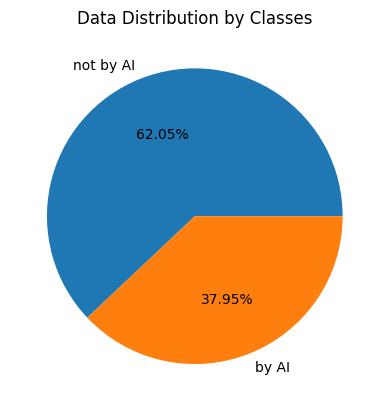

In [ ]:
grouped_df = df[["text", "label"]].groupby(by="label")
class_count = grouped_df.count()

plt.pie(np.squeeze(class_count.values), labels=["not by AI", "by AI"], autopct='%1.2f%%')
plt.title("Data Distribution by Classes")

plt.show()

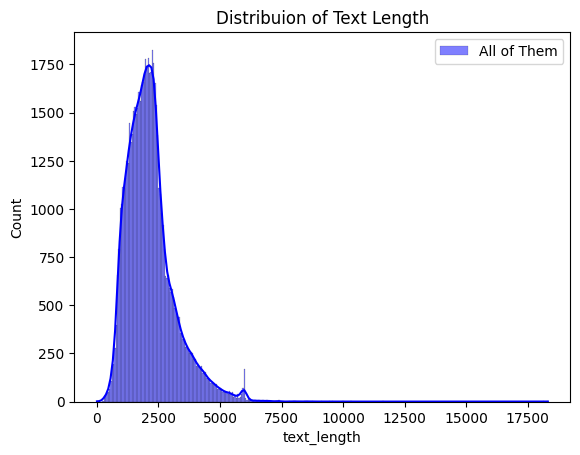

In [ ]:
df['text_length'] = df['text'].apply(len)

sns.histplot(df['text_length'], color="blue", label='All of Them', kde=True)

plt.title("Distribuion of Text Length")
plt.legend()
plt.show()

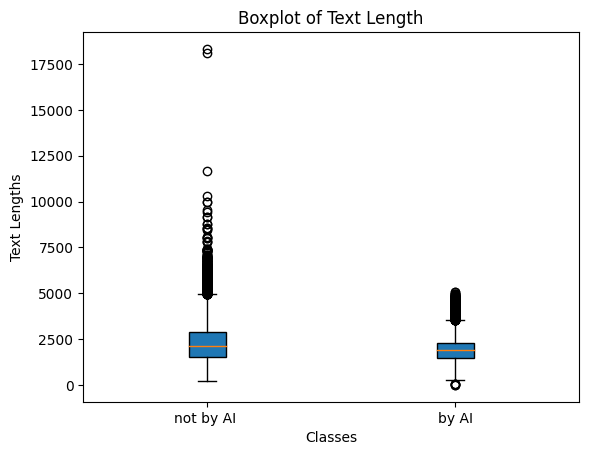

In [ ]:
plt.boxplot([df[df["label"]==0]["text_length"], df[df["label"]==1]["text_length"]], vert=True, patch_artist=True, labels=["not by AI ", "by AI"])

plt.xlabel("Classes")
plt.ylabel("Text Lengths")
plt.title('Boxplot of Text Length')
plt.show()

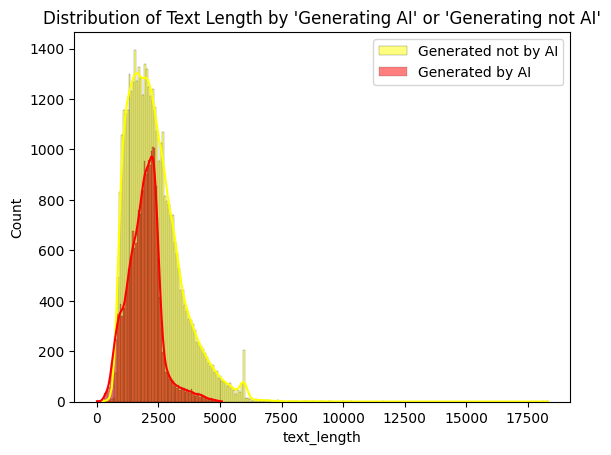

In [ ]:
sns.histplot(df[df["label"]==0]['text_length'], color="yellow", label='Generated not by AI', kde=True)
sns.histplot(df[df["label"]==1]['text_length'], color="red", label='Generated by AI', kde=True)

plt.title("Distribution of Text Length by 'Generating AI' or 'Generating not AI'")
plt.legend()
plt.show()

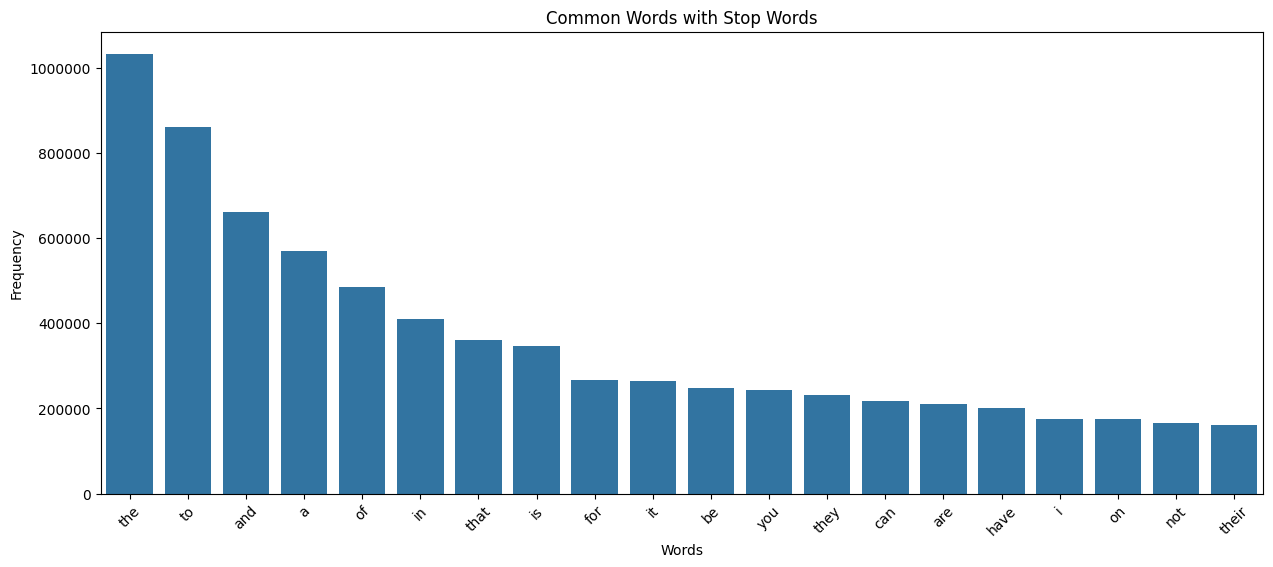

In [ ]:
## Common Words with Stop Words

joined_text = " ".join(df["text"].values).lower()
words = joined_text.split()
word_freq = Counter(words)
common_words = word_freq.most_common(20)

# Plot the most common words
plt.figure(figsize=(15, 6))
sns.barplot(x=[word for word, freq in common_words], y=[freq for word, freq in common_words])

plt.ticklabel_format(style="plain", axis="y")
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title("Common Words with Stop Words")

plt.show()

## Data Preparation
 Punctuations, digits are removed from the dataset. Each word is tokenized and stopwords are deleted. The lemmatization is applied. Each word is processed according to its word type. TF-IDF vectorization is processed. According to the counts of each word, fist N word is selected. 

In [8]:
## This part downloads a larger stopword list. Some missing stopwords are added by hand.

url_link = "https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt"
stopwords_list = requests.get(url_link).content
stopwords_list = stopwords_list.decode().splitlines()

stopwords_list.append("n't")
stopwords_list.append("'s")
stopwords_list.append("'re")
stopwords_list.append("'m")

In [7]:
df.head()

,text,label
0,There are alot reasons to keep our the despise...,0
1,Driving smart cars that drive by themself has ...,0
2,"Dear Principal,\n\nI believe that students at ...",0
3,"Dear Principal,\n\nCommunity service should no...",0
4,My argument for the development of the driverl...,0


In [8]:
"""df_small = df.copy()#df.iloc[:10000].copy()
df_small"""

,text,label
0,There are alot reasons to keep our the despise...,0
1,Driving smart cars that drive by themself has ...,0
2,"Dear Principal,\n\nI believe that students at ...",0
3,"Dear Principal,\n\nCommunity service should no...",0
4,My argument for the development of the driverl...,0
...,...,...
188596,There has been a fuss about the Elector Colleg...,0
188597,Limiting car usage has many advantages. Such a...,0
188598,There's a new trend that has been developing f...,0
188599,As we all know cars are a big part of our soci...,0


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def identity_tokenizer(text):
    return text

def lemmatize_with_pos(token, tag):
    wn_tag = get_wordnet_pos(tag)
    if wn_tag is None:
        return token
    else:
        return lemmatizer.lemmatize(token, pos=wn_tag)


def tokenize_df(df:pd.DataFrame, stopword_list:list):# -> np.ndarray :

    df['tokenized_text'] = df['text'].str.replace('.', '')
    df['tokenized_text'] = df['text'].str.replace('\d+', '') # Remove digits
    df["tokenized_text"] = df["tokenized_text"].apply(lambda each : word_tokenize(each))
    df["tokenized_text"] = df["tokenized_text"].apply(lambda words: [word for word in words if word not in stopword_list])

    df["lemmatized_text"] = df["tokenized_text"].apply(lambda x: [lemmatize_with_pos(token, tag) for token, tag in nltk.pos_tag(x)])
    df["str_lemmatized_text"] = df["tokenized_text"].apply(lambda each : " ".join(each))


    tfidf = TfidfVectorizer( stop_words = stopword_list)

    X = tfidf.fit_transform(df["str_lemmatized_text"].values)

    print("len:", len(tfidf.get_feature_names_out()))
    print(tfidf.get_feature_names_out())

    return X, tfidf.get_feature_names_out()


lemmatizer = WordNetLemmatizer()

X, features = tokenize_df(df, stopwords_list)

C:\Users\Eren\AppData\Local\Temp\ipykernel_15324\1043984238.py:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['tokenized_text'] = df['text'].str.replace('.', '')
C:\Users\Eren\AppData\Local\Temp\ipykernel_15324\1043984238.py:31: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tokenized_text'] = df['text'].str.replace('\d+', '') # Remove digits
C:\ProgramData\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['articl', 'mon'] not in stop_words.
  warnings.warn(


len: 84240
['___' '_____' '______' ... '司机必须在驾驶时将全部注意力都集中在道路上'
 '完全禁止使用手机应该是合法和道路安全的唯一选择' '書道']


In [19]:
X.shape, type(X)

((188601, 84240), scipy.sparse._csr.csr_matrix)

In [71]:
## This part is save the dataset for using easily in the future.

base_dataset_path = r"C:\Users\Eren\Desktop\notlar\lesson notes\dönem 6\AIN423 - Data Intensive Applications\Data Science Course Project\models"

y = df["label"]
np.save(os.path.join(base_dataset_path, "X_all.npy"), X)
np.save(os.path.join(base_dataset_path, "y_all.npy"), y)
np.save(os.path.join(base_dataset_path, "features_all.npy"), features)

In [12]:
def find_top_n_words(n, X):
    tfidf_scores = X.sum(axis=0)

    # Combine feature List and TF-IDF Scores.
    word_scores = [(idx, word, tfidf_scores[0, idx]) for idx,word in enumerate(features) if len(word)>=3]

    # Sort by TF-IDF scores.
    word_scores.sort(key=lambda x: x[2], reverse=True)

    # Iterate n times to find n most common words. Put them into list
    top_n_words = []
    top_n_idx = []

    for i in range(n):
        idx, word, score = word_scores[i]
        #top_n_words.append(word)
        top_n_idx.append(idx)

    X_top_n = X[:, top_n_idx]
    return X_top_n


In [58]:
## FOR LOADING 

from scipy.sparse import csr_matrix

X = np.load("../models/X_all.npy", allow_pickle=True)
y = np.load("../models/y_all.npy", allow_pickle=True)
features = np.load("../models/features_all.npy", allow_pickle=True)

X = csr_matrix(X.all())

In [48]:
N = 25
X_top_25 = find_top_n_words(n=N, X=X)

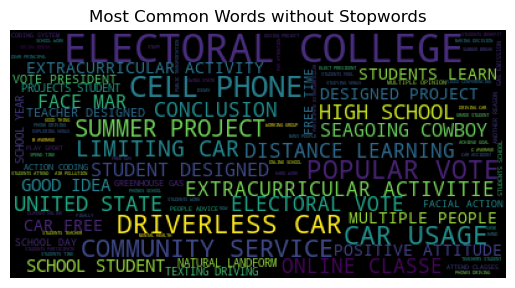

In [16]:
def cloud(text):
    wordcloud = WordCloud().generate(" ".join([i for i in text.str.upper()]))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Most Common Words without Stopwords")

cloud(df_small["str_lemmatized_text"])

In [79]:
def plot_loss_acc(history:dict, model_name:str):
    fig, axs = plt.subplots(1,3, figsize=(18,5))

    fig.suptitle(model_name)

    axs[0].plot(history["accuracy"], label="train")
    axs[0].plot(history["val_accuracy"], label="validation")
    axs[0].set_title("Accuracy-Epoch")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")

    axs[1].plot(history["loss"], label="train")
    axs[1].plot(history["val_loss"], label="validation")
    axs[1].set_title("Loss-Epoch")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="lower left")

    axs[2].plot(history["auc_2"], label="train")
    axs[2].plot(history["val_auc_2"], label="validation")
    axs[2].set_title("AUC-Epoch")
    axs[2].set_xlabel("Epoch")
    axs[2].set_ylabel("AUC")
    axs[2].legend(loc="lower left")

    plt.show()

## MODELLING
Machine learning models and LSTM for deep learning model is used. Binary cross-enstropy is used as loss function and Adam optimizer is used as optimizer. LSTM model has a LSTM layer and 2 dense layer with ReLU and Sigmoid activation functions respectively. 

In [37]:
## Create Dataset

y = df_small["label"].values.reshape(-1, 1)

X_train_val, X_test, y_train_val, y_test = train_test_split(X_top_100, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=20/85, random_state=42)

X_train = X_train.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()

X_train_re = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val_re = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test_re = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_train_re.shape)
print(X_val_re.shape, y_val.shape, X_val_re.shape)
print(X_test.shape, y_test.shape, X_test_re.shape)

(122590, 100) (122590, 1) (122590, 1, 100)
(37720, 1, 100) (37720, 1) (37720, 1, 100)
(28291, 100) (28291, 1) (28291, 1, 100)


In [61]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=128, input_shape=(1, input_shape), return_sequences=True))  # input_shape, (time_steps, features)
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.AUC()])
    return model


# This part is used for N=100 common words


In [41]:
lstm = create_lstm_model(input_shape=X_train_re.shape[2])

epochs = 50
batch_size = 16

history = lstm.fit(X_train_re, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_re, y_val))

Epoch 1/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.8789 - auc_8: 0.9347 - loss: 0.2792 - val_accuracy: 0.9203 - val_auc_8: 0.9716 - val_loss: 0.1961
Epoch 2/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9235 - auc_8: 0.9725 - loss: 0.1900 - val_accuracy: 0.9326 - val_auc_8: 0.9784 - val_loss: 0.1687
Epoch 3/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9356 - auc_8: 0.9802 - loss: 0.1608 - val_accuracy: 0.9422 - val_auc_8: 0.9833 - val_loss: 0.1487
Epoch 4/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9421 - auc_8: 0.9840 - loss: 0.1453 - val_accuracy: 0.9445 - val_auc_8: 0.9851 - val_loss: 0.1411
Epoch 5/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9452 - auc_8: 0.9860 - loss: 0.1357 - val_accuracy: 0.9489 - val_auc_8: 0.9863 - val_loss: 0.1340
Epoch 6/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9492 - auc_8: 0.9880 - loss: 0.1253 - val_accuracy: 0.9503 - val_auc_8: 0.9889 - val_loss: 0.126

7662/7662 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9927 - auc_8: 0.9995 - loss: 0.0202 - val_accuracy: 0.9876 - val_auc_8: 0.9962 - val_loss: 0.0500
Epoch 42/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9933 - auc_8: 0.9995 - loss: 0.0191 - val_accuracy: 0.9878 - val_auc_8: 0.9959 - val_loss: 0.0498
Epoch 43/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9934 - auc_8: 0.9994 - loss: 0.0193 - val_accuracy: 0.9876 - val_auc_8: 0.9959 - val_loss: 0.0516
Epoch 44/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9939 - auc_8: 0.9996 - loss: 0.0173 - val_accuracy: 0.9880 - val_auc_8: 0.9953 - val_loss: 0.0497
Epoch 45/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9944 - auc_8: 0.9996 - loss: 0.0172 - val_accuracy: 0.9853 - val_auc_8: 0.9953 - val_loss: 0.0569
Epoch 46/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9948 - auc_8: 0.9996 - loss: 0.0154 - val_accuracy: 0.9888 - val_auc_8: 0.9952 - val_loss: 0.0515
Epoc

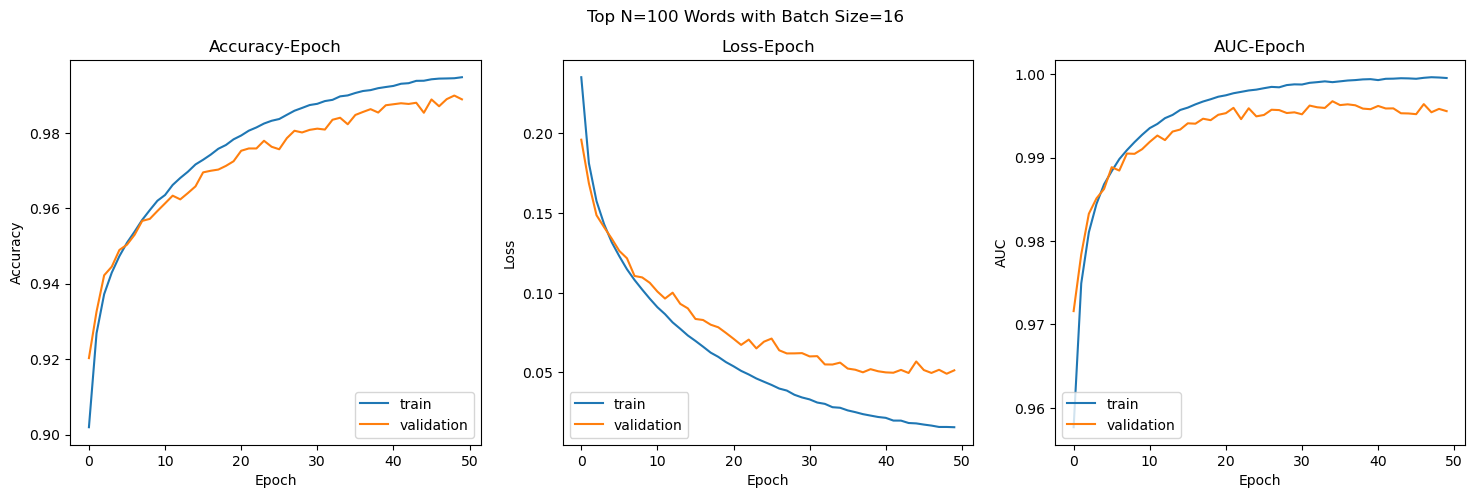

In [43]:
plot_loss_acc(history.history, "Top N=100 Words with Batch Size=16")

In [44]:
print("LSTM Testing")

loss, accuracy, auc= lstm.evaluate(X_test_re, y_test, batch_size=16)

LSTM Testing
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9886 - auc_8: 0.9965 - loss: 0.0484


In [69]:
lstm.save("lstm-all-n_100-e_50.keras")
np.save('lstm-all-n_100-e_50-history.npy',history.history)


## Logistic Regression


In [30]:
log_reg = LogisticRegression(random_state=0).fit(X_train, y_train)

y_pred_tra = log_reg.predict(X_train)
y_pred = log_reg.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_tra)
test_acc = accuracy_score(y_test, y_pred)

train_f1 = f1_score(y_train, y_pred_tra)
test_f1 = f1_score(y_test, y_pred)

print("Logistic Regression")
print(f"Train Accuracy : {train_acc:.4f} , Train F1 : {train_f1:.4f}")
print(f"Test Accuracy : {test_acc:.4f} , Test F1 : {test_f1:.4f}")

Logistic Regression
Train Accuracy : 0.8968 , Train F1 : 0.8210
Test Accuracy : 0.8939 , Test F1 : 0.8179


## Naive Bayes

In [31]:
multinomial_nb = MultinomialNB(alpha=0.02)
multinomial_nb.fit(X_train, y_train)

y_pred_tra = multinomial_nb.predict(X_train)
y_pred = multinomial_nb.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_tra)
test_acc = accuracy_score(y_test, y_pred)

train_f1 = f1_score(y_train, y_pred_tra)
test_f1 = f1_score(y_test, y_pred)

print("NAIVE BAYES")
print(f"Train Accuracy : {train_acc:.4f} , Train F1 : {train_f1:.4f}")
print(f"Test Accuracy : {test_acc:.4f} , Test F1 : {test_f1:.4f}")


NAIVE BAYES
Train Accuracy : 0.7334 , Train F1 : 0.2241
Test Accuracy : 0.7319 , Test F1 : 0.2313


## XGBoost


In [32]:
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)

y_pred_tra = xgboost.predict(X_train)
y_pred = xgboost.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_tra)
test_acc = accuracy_score(y_test, y_pred)

train_f1 = f1_score(y_train, y_pred_tra)
test_f1 = f1_score(y_test, y_pred)

print("XGBOOST")
print(f"Train Accuracy : {train_acc:.4f} , Train F1 : {train_f1:.4f}")
print(f"Test Accuracy : {test_acc:.4f} , Test F1 : {test_f1:.4f}")

XGBOOST
Train Accuracy : 0.9769 , Train F1 : 0.9608
Test Accuracy : 0.9674 , Test F1 : 0.9447


# This part is used for the first N=50 common words.

In [58]:
## Create Dataset
y = df_small["label"].values.reshape(-1, 1)

X_train_val, X_test, y_train_val, y_test = train_test_split(X_top_50, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=20/85, random_state=42)

X_train = X_train.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()

X_train_re = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val_re = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test_re = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_train_re.shape)
print(X_val_re.shape, y_val.shape, X_val_re.shape)
print(X_test.shape, y_test.shape, X_test_re.shape)

(122590, 50) (122590, 1) (122590, 1, 50)
(37720, 1, 50) (37720, 1) (37720, 1, 50)
(28291, 50) (28291, 1) (28291, 1, 50)


In [53]:
N = 50
X_top_50 = find_top_n_words(n=N, X=X)

In [60]:
lstm_2 = create_lstm_model(input_shape=X_train_re.shape[2])

epochs = 50
batch_size = 16

history_2 = lstm_2.fit(X_train_re, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_re, y_val))

Epoch 1/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.8354 - auc_14: 0.8902 - loss: 0.3688 - val_accuracy: 0.8806 - val_auc_14: 0.9404 - val_loss: 0.2814
Epoch 2/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.8840 - auc_14: 0.9428 - loss: 0.2755 - val_accuracy: 0.8903 - val_auc_14: 0.9502 - val_loss: 0.2613
Epoch 3/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8926 - auc_14: 0.9504 - loss: 0.2569 - val_accuracy: 0.8932 - val_auc_14: 0.9546 - val_loss: 0.2537
Epoch 4/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8969 - auc_14: 0.9543 - loss: 0.2468 - val_accuracy: 0.8998 - val_auc_14: 0.9587 - val_loss: 0.2389
Epoch 5/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9014 - auc_14: 0.9584 - loss: 0.2356 - val_accuracy: 0.9028 - val_auc_14: 0.9610 - val_loss: 0.2295
Epoch 6/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9043 - auc_14: 0.9615 - loss: 0.2275 - val_accuracy: 0.9052 - val_auc_14: 0.9632 - val

7662/7662 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9514 - auc_14: 0.9894 - loss: 0.1188 - val_accuracy: 0.9420 - val_auc_14: 0.9843 - val_loss: 0.1462
Epoch 42/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9533 - auc_14: 0.9901 - loss: 0.1148 - val_accuracy: 0.9426 - val_auc_14: 0.9843 - val_loss: 0.1448
Epoch 43/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9544 - auc_14: 0.9903 - loss: 0.1135 - val_accuracy: 0.9417 - val_auc_14: 0.9852 - val_loss: 0.1466
Epoch 44/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9538 - auc_14: 0.9903 - loss: 0.1138 - val_accuracy: 0.9436 - val_auc_14: 0.9855 - val_loss: 0.1419
Epoch 45/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9546 - auc_14: 0.9906 - loss: 0.1118 - val_accuracy: 0.9457 - val_auc_14: 0.9857 - val_loss: 0.1387
Epoch 46/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9555 - auc_14: 0.9910 - loss: 0.1094 - val_accuracy: 0.9470 - val_auc_14: 0.9857 - val_loss:

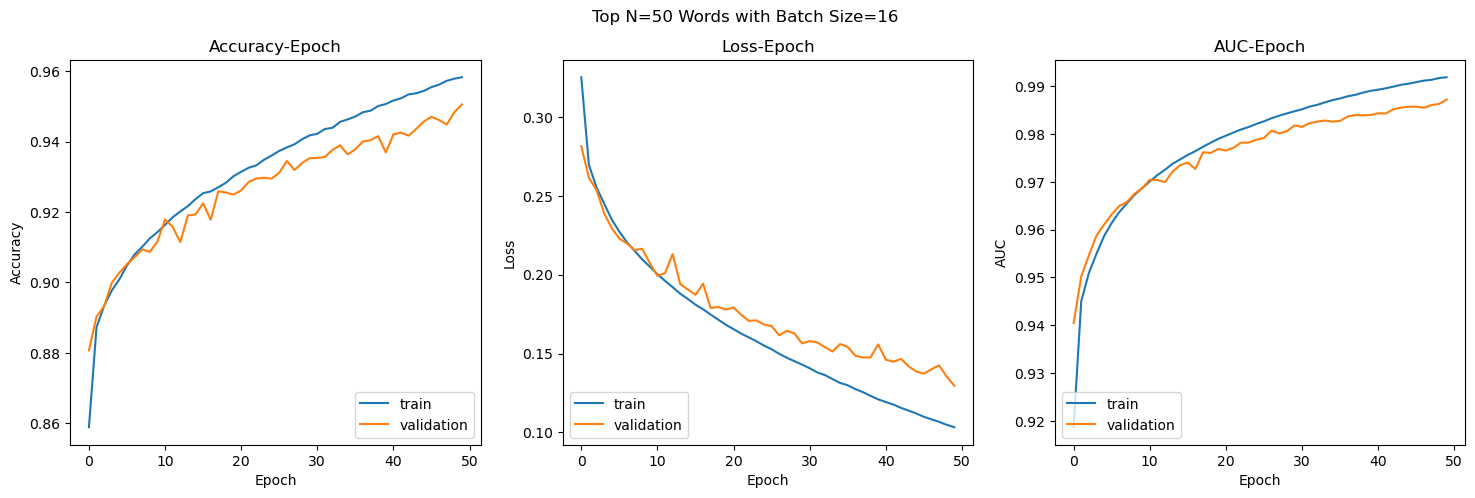

In [63]:
plot_loss_acc(history_2.history, "Top N=50 Words with Batch Size=16")

In [64]:
print("LSTM Testing")

loss, accuracy, auc = lstm_2.evaluate(X_test_re, y_test, batch_size=16)

LSTM Testing
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - accuracy: 0.9475 - auc_14: 0.9860 - loss: 0.1358


In [70]:
lstm_2.save("lstm_2-all-n_100-e_50.keras")
np.save('lstm_2-all-n_100-e_50-history.npy', history_2.history)


## Logistic Regression


In [65]:
log_reg = LogisticRegression(random_state=0).fit(X_train, y_train)

y_pred_tra = log_reg.predict(X_train)
y_pred = log_reg.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_tra)
test_acc = accuracy_score(y_test, y_pred)

train_f1 = f1_score(y_train, y_pred_tra)
test_f1 = f1_score(y_test, y_pred)

print("Logistic Regression")
print(f"Train Accuracy : {train_acc:.4f} , Train F1 : {train_f1:.4f}")
print(f"Test Accuracy : {test_acc:.4f} , Test F1 : {test_f1:.4f}")

C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression
Train Accuracy : 0.8462 , Train F1 : 0.7298
Test Accuracy : 0.8422 , Test F1 : 0.7245


## Naive Bayes


In [66]:
multinomial_nb = MultinomialNB(alpha=0.02)
multinomial_nb.fit(X_train, y_train)

y_pred_tra = multinomial_nb.predict(X_train)
y_pred = multinomial_nb.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_tra)
test_acc = accuracy_score(y_test, y_pred)

train_f1 = f1_score(y_train, y_pred_tra)
test_f1 = f1_score(y_test, y_pred)

print("NAIVE BAYES")
print(f"Train Accuracy : {train_acc:.4f} , Train F1 : {train_f1:.4f}")
print(f"Test Accuracy : {test_acc:.4f} , Test F1 : {test_f1:.4f}")


NAIVE BAYES
Train Accuracy : 0.7028 , Train F1 : 0.0088
Test Accuracy : 0.7003 , Test F1 : 0.0096


C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## XGBoost


In [67]:
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)

y_pred_tra = xgboost.predict(X_train)
y_pred = xgboost.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_tra)
test_acc = accuracy_score(y_test, y_pred)

train_f1 = f1_score(y_train, y_pred_tra)
test_f1 = f1_score(y_test, y_pred)

print("XGBOOST")
print(f"Train Accuracy : {train_acc:.4f} , Train F1 : {train_f1:.4f}")
print(f"Test Accuracy : {test_acc:.4f} , Test F1 : {test_f1:.4f}")

XGBOOST
Train Accuracy : 0.9460 , Train F1 : 0.9087
Test Accuracy : 0.9367 , Test F1 : 0.8927


# This part is used for the first N=25 common words.

In [73]:
## Create Dataset
y = y.reshape(-1,1) #df_small["label"].values.reshape(-1, 1)

X_train_val, X_test, y_train_val, y_test = train_test_split(X_top_25, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=20/85, random_state=42)

X_train = X_train.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()

X_train_re = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val_re = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test_re = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_train_re.shape)
print(X_val_re.shape, y_val.shape, X_val_re.shape)
print(X_test.shape, y_test.shape, X_test_re.shape)


(122590, 25) (122590, 1) (122590, 1, 25)
(37720, 1, 25) (37720, 1) (37720, 1, 25)
(28291, 25) (28291, 1) (28291, 1, 25)


In [75]:
lstm_3 = create_lstm_model(input_shape=X_train_re.shape[2])

epochs = 50
batch_size = 16

history_3 = lstm_3.fit(X_train_re, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_re, y_val))

Epoch 1/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.7976 - auc_2: 0.8403 - loss: 0.4339 - val_accuracy: 0.8172 - val_auc_2: 0.8882 - val_loss: 0.3913
Epoch 2/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.8311 - auc_2: 0.8939 - loss: 0.3685 - val_accuracy: 0.8372 - val_auc_2: 0.9019 - val_loss: 0.3575
Epoch 3/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8392 - auc_2: 0.9029 - loss: 0.3536 - val_accuracy: 0.8317 - val_auc_2: 0.9054 - val_loss: 0.3655
Epoch 4/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.8454 - auc_2: 0.9101 - loss: 0.3411 - val_accuracy: 0.8494 - val_auc_2: 0.9138 - val_loss: 0.3369
Epoch 5/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.8488 - auc_2: 0.9129 - loss: 0.3359 - val_accuracy: 0.8488 - val_auc_2: 0.9145 - val_loss: 0.3354
Epoch 6/50
7662/7662 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.8534 - auc_2: 0.9167 - loss: 0.3300 - val_accuracy: 0.8551 - val_auc_2: 0.9202 - val_loss: 0.325

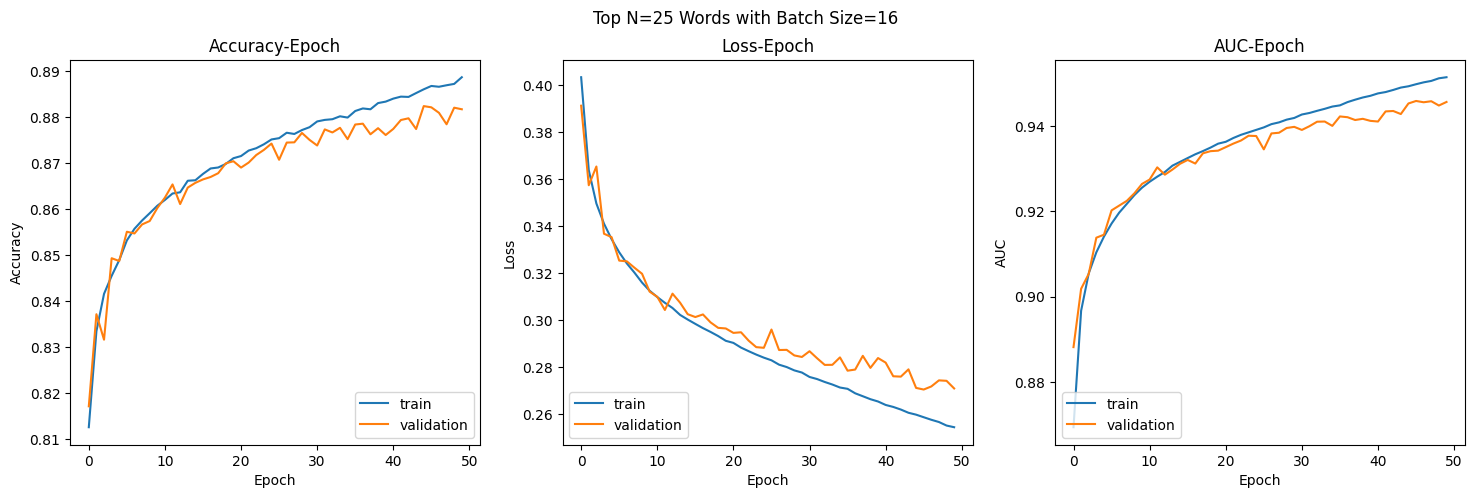

In [80]:
plot_loss_acc(history_3.history, "Top N=25 Words with Batch Size=16")

In [81]:
print("LSTM Testing")

loss, accuracy, auc = lstm_3.evaluate(X_test_re, y_test, batch_size=16)

LSTM Testing
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 1s 624us/step - accuracy: 0.8792 - auc_2: 0.9448 - loss: 0.2722


In [82]:
lstm_3.save("lstm_3-all-n_25-e_50.keras")
np.save('lstm_3-all-n_25-e_50-history.npy', history_3.history)


## Logistic Regression


In [83]:
log_reg = LogisticRegression(random_state=0).fit(X_train, y_train)

y_pred_tra = log_reg.predict(X_train)
y_pred = log_reg.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_tra)
test_acc = accuracy_score(y_test, y_pred)

train_f1 = f1_score(y_train, y_pred_tra)
test_f1 = f1_score(y_test, y_pred)

print("Logistic Regression")
print(f"Train Accuracy : {train_acc:.4f} , Train F1 : {train_f1:.4f}")
print(f"Test Accuracy : {test_acc:.4f} , Test F1 : {test_f1:.4f}")

C:\Users\Eren\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression
Train Accuracy : 0.8054 , Train F1 : 0.6419
Test Accuracy : 0.8029 , Test F1 : 0.6411


## Naive Bayes

In [84]:
multinomial_nb = MultinomialNB(alpha=0.02)
multinomial_nb.fit(X_train, y_train)

y_pred_tra = multinomial_nb.predict(X_train)
y_pred = multinomial_nb.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_tra)
test_acc = accuracy_score(y_test, y_pred)

train_f1 = f1_score(y_train, y_pred_tra)
test_f1 = f1_score(y_test, y_pred)

print("NAIVE BAYES")
print(f"Train Accuracy : {train_acc:.4f} , Train F1 : {train_f1:.4f}")
print(f"Test Accuracy : {test_acc:.4f} , Test F1 : {test_f1:.4f}")


NAIVE BAYES
Train Accuracy : 0.7052 , Train F1 : 0.0000
Test Accuracy : 0.7029 , Test F1 : 0.0000


C:\Users\Eren\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## XGBoost

In [85]:
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)

y_pred_tra = xgboost.predict(X_train)
y_pred = xgboost.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_tra)
test_acc = accuracy_score(y_test, y_pred)

train_f1 = f1_score(y_train, y_pred_tra)
test_f1 = f1_score(y_test, y_pred)

print("XGBOOST")
print(f"Train Accuracy : {train_acc:.4f} , Train F1 : {train_f1:.4f}")
print(f"Test Accuracy : {test_acc:.4f} , Test F1 : {test_f1:.4f}")

XGBOOST
Train Accuracy : 0.9008 , Train F1 : 0.8303
Test Accuracy : 0.8888 , Test F1 : 0.8114


**Disclaimer!** <font color='grey'>This notebook was prepared by <Mehmet Eren SOYKÖK and Harun HARMAN> as a term project for the *AIN423 - Data Intensive Applications* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>